<a href="https://colab.research.google.com/github/allenthemartian/CNN/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Serial Experimentation

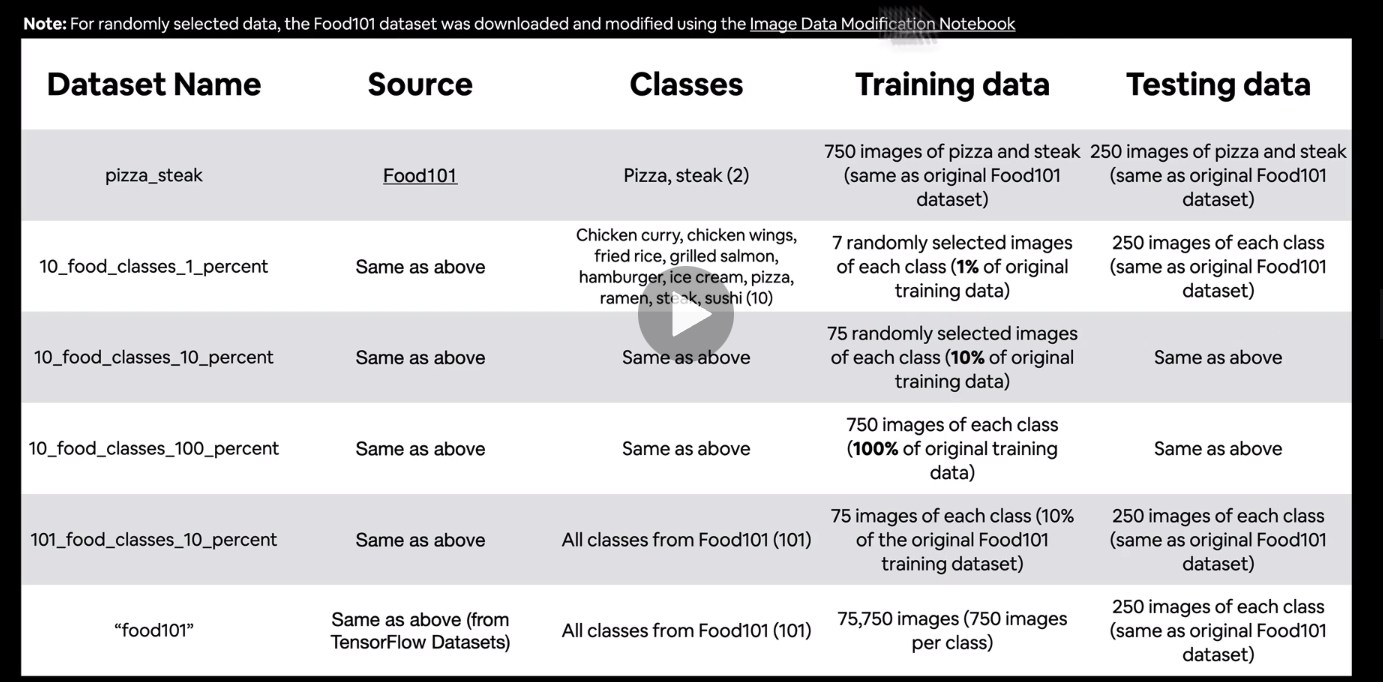

# Milestone Project 1: Food Vision Big

In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 3.8 MB 36.3 MB/s 
     |████████████████████████████████| 2.9 MB 30.0 MB/s 
     |████████████████████████████████| 462 kB 49.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.4.1


## Check GPU  

If we want to get the benefits of **mixed-precision training** (faster model training), the GPU needs to be supported (compute capability of 7.0+) - meaning they have special hardware units called *Tensor Cores*.  

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)  

Knowing this, in order to use mixed precision training, we need to access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus)   


*Why does this help?*  

Those with compute compatiblity 7.0 or higher will see the greatest performance benefit from mixed precision because they have special hardware units, called **Tensor Cores**, to accelerate float16 matrix multiplications and convolutions.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b07a161b-2d67-52ff-6a90-e8e8b5cd678a)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.  

Rather than rewrite all of these, we can import a script and load them in from there. 


In [ ]:
#@title ######Function to import helper functions
import requests
from io import StringIO
import getpass

def pull_helper_functions(repo, path, owner="allenthemartian"):

  '''
  Args:
  
  `repo`: Name of repository
  `path`: filename/filepath
  `token`: Encrypted [GitHub Personal Access Token] Fernet Key
  `owner`: Github Account name
  
  Imports:
  
  `import requests`
  `from io import StringIO`
  `import getpass`
  '''
  token = getpass.getpass(prompt="Github Personal Access Token: ")

  r = requests.get(
    'https://api.github.com/repos/{owner}/{repo}/contents/{path}'.format(
    owner=owner, repo=repo, path=path),
    headers={
        'accept': 'application/vnd.github.v3.raw',
        'authorization': 'token {}'.format(token)
            }
    )
  
  string_io_obj = StringIO(r.text)

  with open(f"{path}", mode='w') as f:
    print(string_io_obj.getvalue(), file=f)
  
  print("Check your colab drive for file.")

In [ ]:
pull_helper_functions(repo="TDC", path="my_custom_helper_functions.py", owner="allenthemartian")

Github Personal Access Token: ··········
Check your colab drive for file.


In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-11 05:32:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-11 05:32:22 (87.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of Helper Functions for our notebook
from helper_functions import create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir 
from my_custom_helper_functions import set_cell_size, count_params, plot_loss_curves, trainable_layers, view_random_image 

## Use TensorFlow Datasets to Download Data  

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [ ]:
import tensorflow_datasets as tfds

# list available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBSTQGX/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBSTQGX/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Output of downloading TFDS --> Stored in *cache*, thus output won't reappear when you run the cell again. 

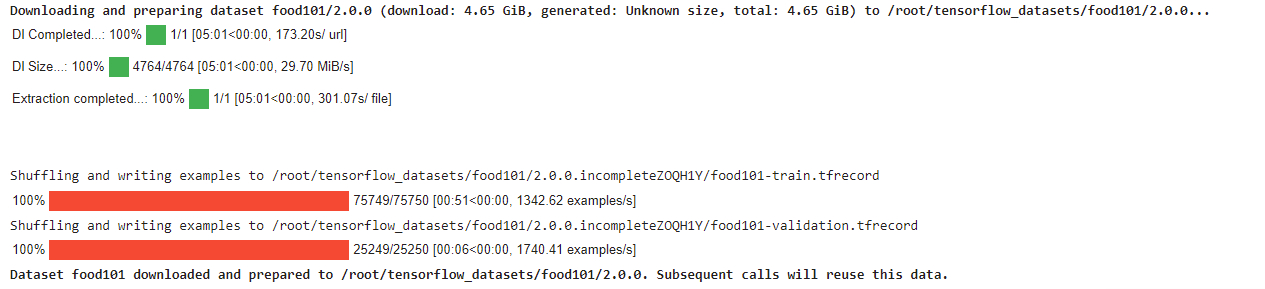

## Exploring the Food101 data from TensorFlow Datasets  

To become on with our data, we want to find:  
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the `train` data
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
train_one_sample = train_data.take(1) #Sample are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}   
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 16,
  Class name (str form): cheesecake   
  


Image class dataset is NOT one-hot encoded, thus the loss function required to be used is `sparse_categorical_crossentropy`

In [ ]:
set_cell_size()

# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot and image from TensorFlow Datasets 


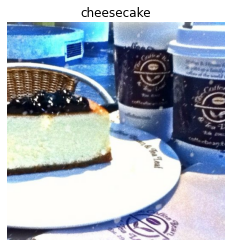

In [ ]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data  

NNs perform best when data is in a certain way (e.g *batched*, *normalized*, etc.)

However, not all data (including data from TensorFlow Datasets) come like this.   

So in order to get it ready for a NN, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixels are between $0$ and $255$  

What we know models like:  
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values b/w $0$ & $1$) also called Normalized Tensors, generally perform better.  

With these points in mind, we've got a few things we can tackle with a preprocessing function.  

Since we're going to be using an EfficientNetBX (0-7) pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).  

This means our functions need to:  
1. Reshape our images to all the same size  
2. Convert the dtype of our image tensors from `unint8` to `float32`

In [ ]:
# (image, label)

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' --> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(images=image, size=[img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required for EfficientNetBX)
  # Casts tensor to new type
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprecessing: \n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprecessing: 
[[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



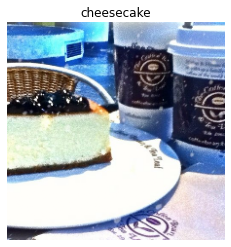

In [ ]:
# Plot preprocessed image tensor
plt.imshow(preprocessed_img/255.) # EfficientNetBX has rescaling built in
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Batch & Prepare Datasets  

We're going to make our data input pipeline run really fast.  

For more, resources, highly recommended going through the following guide:
https://www.tensorflow.org/guide/data_performance  

1. Apply our `preprocess_img` function to all of our Tensors in our TFDS  
2. Turn our Tensors into *Batches* so that they compute as efficiently as possible on our GPU.  


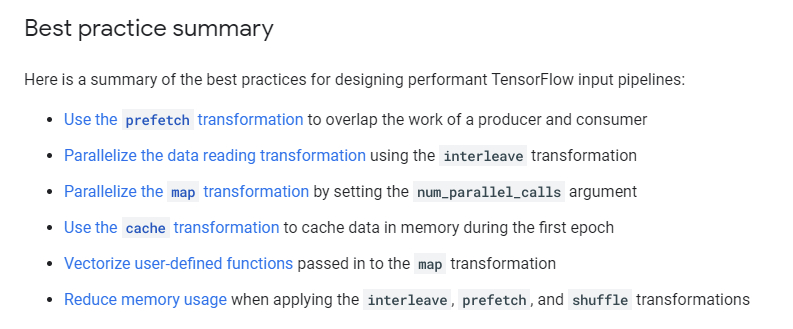

In [ ]:
# data type
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

>`num_parallel_calls = tf.data.AUTOTUNE` 
>
>When you try to map the function: `preprocess_img` to the `train_data`, b/c there are so many images, utilize all of the compute power you can find.  
>
>That's what `AUTOTUNE` stands for.  
>
>Default: Utilizes only $1$ CPU chip.  

$\Rightarrow$ Very important if we're ever mapping functions to our datasets.  


>`buffer_size=1000`
>
>Ideally every element in the training data, so we could set it as `len(train_data)`.  
>
>Depending what how much compute capacity we have, it may not be able to store the data in storage.  
>
>We will instead set it to a $1,000$ or $10,000$

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE) # TF automatically TUNE the NO. OF PROCESSES USED

# Shuffle train data and turn it into batches and prefetch it (load it faster)
    #`buffer_size` = how many elements to shuffle at a single time
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  

# Map preprocess function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Use .cache() to store the preprocessED data instead of preprocessing again (Only works if data can fit into RAM)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

`train_data` and `test_data` are now *PrefetchDataset*

><_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>  

>(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>  


`preprocess_img` function has changed the image tensor shape: (___, 224, 224, 3)  

It has also added another slot at the beginning for *batch size*.  

It also changes the datatype from `unint8` $\longrightarrow$ `float32`



What's actually going on above?
> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

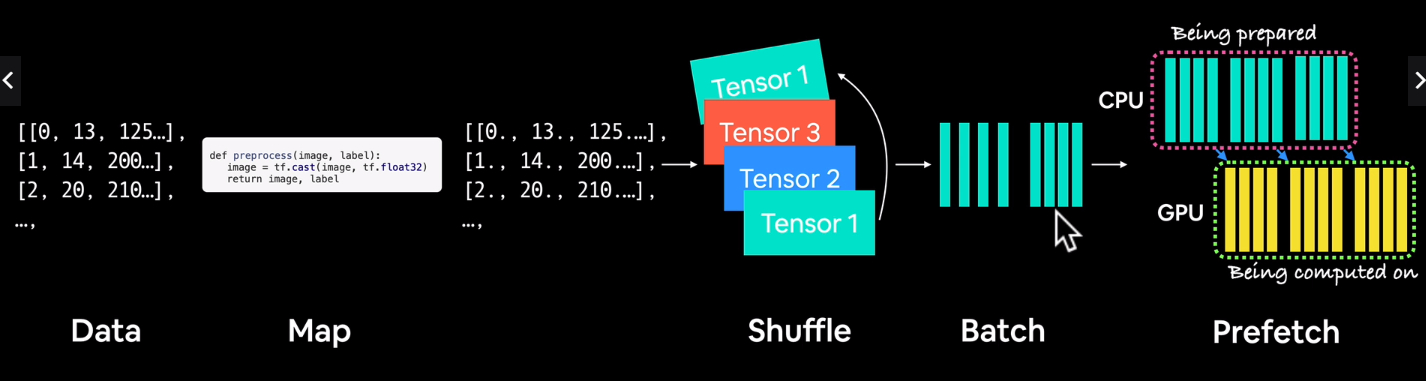

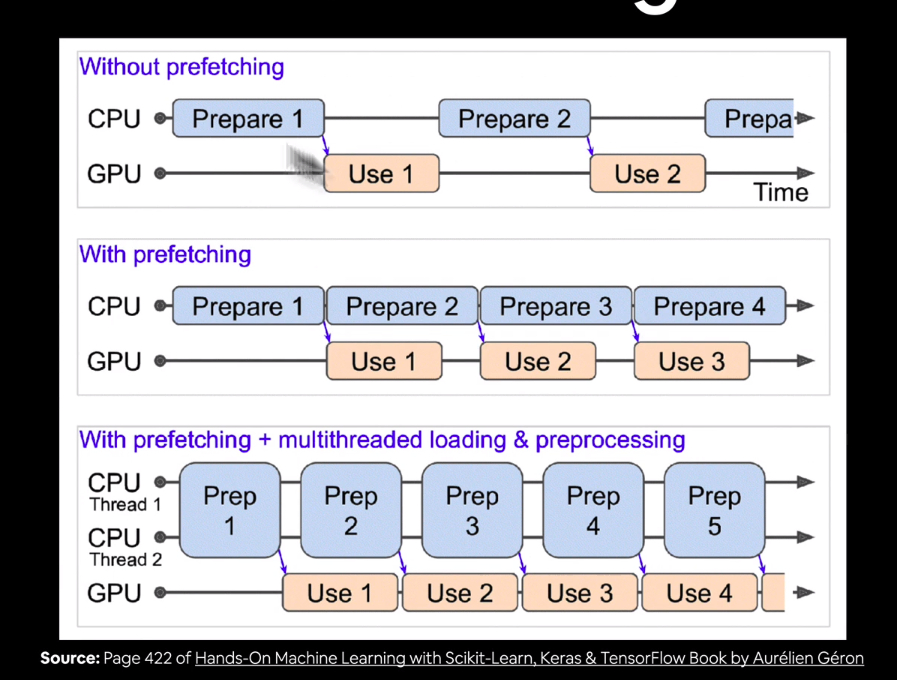

## Creating Modelling Callbacks  

We're going to create a couple of callbacks to help us while our model trains:  
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.  



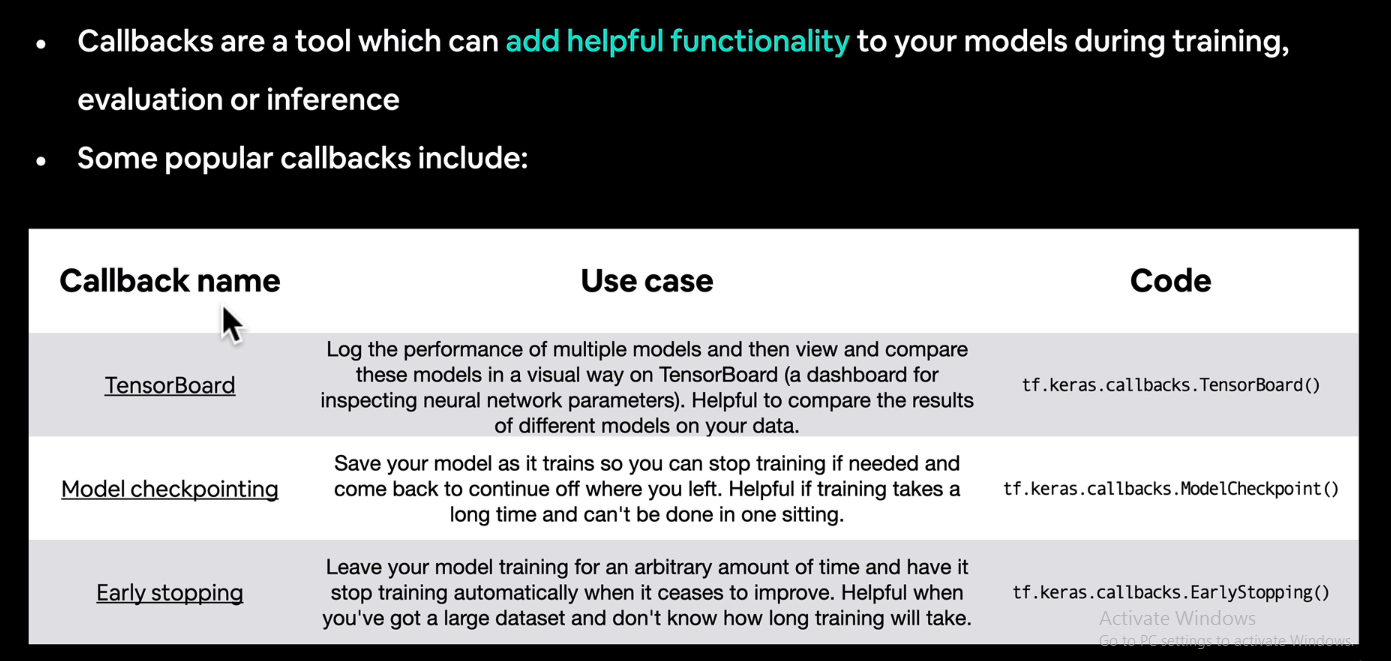 

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

In [ ]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"  

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # Don't print whether or not model is being saved

In [ ]:
# print(tf.__version__)

In [ ]:
# !pip install tensorflow==2.4.1

## Setup Mixed Precision Training  

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision  

Mixed precision utilizes a combination of float32 and float16, data types to speed up model performance.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Turn on Mixed Precision Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set Global Data Policy to mixed precision 

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
!nvidia-smi

Mon Oct 11 05:42:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    59W / 149W |    141MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPU $\rightarrow$ has limited amount of storage.  

Tesla K80 $\rightarrow$  11441MiB (a limited amount of storage in bytes)

Only a certain amount of `float32` Tensors can fit in GPU storage, but with Mixed Precision training using both `float16` and `float32` dtypes,

>Modern accelerators can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.  



In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

When using **Mixed Precision Training**, and *building* the model, it requires the *output layer* to have `dtype=tf.float32`  

If the output of the model is in `tf.float16`, it may not be *numerically stable*.    

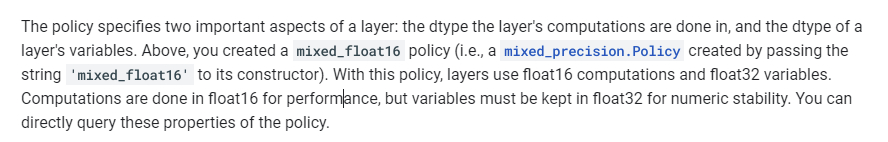

_________________________________________

Pass it as a parameter into the `output` layer:  

e.g.  

```
outputs = layers.Activation('softmax', dtype='float32', name='predictions')(x)
```  



## Build Feature Extraction Model

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Create a base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional Model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")  

#Note: EfficientNetBX models have rescaling built-in, but if your model doesn't, you can have a layer like below:
# x = preprocessing.Rescaling(1/255.)(`previous layer`)

x = base_model(inputs, training=False) # Makes sure layers which should be in inference

x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(x.dtype)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
print(outputs.dtype)

model = tf.keras.Model(inputs, outputs)  

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step
<dtype: 'float16'>
<dtype: 'float32'>


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=16>

`label` is in `dtype=int64` and not one-hot encoded.

In [ ]:
def inspect_mixed_precision(model):
  '''
  Args:
    `model`: Pass in a TF model.
  Returns:
  
    `tabulate` Table with headers: No., Layer Name, Computation dtype, Variable dtype
  
  --Index - Index Position of Layer
  --Name - Layer name, user defined in parameter `name`
  --Computation dtype - The datatype policy a layer computes on its variables
  --Variable dtype - float16, float32 --> The datatype layer in which it stores its variables  
  
  
  Imports:  
    `from tabulate import tabulate`
  '''
  layer_num = []
  layer_name = []
  layer_dtype_policy = []
  layer_dtype = []
  headers = ["Index", "Layer Name", "Computation dtype", "Variable dtype"]
  for i, layer in enumerate(model.layers):
    layer_num.append(i)
    layer_name.append(layer.name)
    layer_dtype_policy.append(layer.dtype_policy)
    layer_dtype.append(layer.dtype)
    # if isinstance(layer.dtype, )
  table = zip(layer_num, layer_name, layer_dtype_policy, layer_dtype)
  print(tabulate(table, headers=headers, tablefmt="orgtbl"))

**NOTE:** Computations are done in `float16` for performance, but variables must be kept in `float32` for numeric stability.

In [ ]:
from tabulate import tabulate
inspect_mixed_precision(model)

|   Index | Layer Name               | Computation dtype        | Variable dtype   |
|---------+--------------------------+--------------------------+------------------|
|       0 | input_layer              | <Policy "float32">       | float32          |
|       1 | efficientnetb0           | <Policy "mixed_float16"> | float32          |
|       2 | global_average_pooling2d | <Policy "mixed_float16"> | float32          |
|       3 | dense                    | <Policy "mixed_float16"> | float32          |
|       4 | softmax_float32          | <Policy "float32">       | float32          |


Going through the above we see:
  
* `layer_name`: The human readable name of a particular layer
* `layer_trainable`: Is the layer trainable or not (if `False`, the weights are Frozen)
* `layer.dtype`: The datatype a layer stores its variables in.
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with

In [ ]:
# Inspect `base_model`
inspect_mixed_precision(model)

|   Index | Layer Name               | Computation dtype        | Variable dtype   |
|---------+--------------------------+--------------------------+------------------|
|       0 | input_layer              | <Policy "float32">       | float32          |
|       1 | efficientnetb0           | <Policy "mixed_float16"> | float32          |
|       2 | global_average_pooling2d | <Policy "mixed_float16"> | float32          |
|       3 | dense                    | <Policy "mixed_float16"> | float32          |
|       4 | softmax_float32          | <Policy "float32">       | float32          |


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:  

1. Build a feature extraction model (train a couple output layers with base layers frozen)  
2. Fine-tune some of the frozen layers.  

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="EfficientNetB0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/EfficientNetB0_101_classes_all_data_feature_extract/20211011-054302
Epoch 1/3
2368/2368 [==============================] - 301s 108ms/step - loss: 2.3254 - accuracy: 0.4642 - val_loss: 1.2370 - val_accuracy: 0.6712
Epoch 2/3
2368/2368 [==============================] - 241s 101ms/step - loss: 1.3135 - accuracy: 0.6616 - val_loss: 1.1238 - val_accuracy: 0.6988
Epoch 3/3
2368/2368 [==============================] - 240s 101ms/step - loss: 1.1509 - accuracy: 0.7002 - val_loss: 1.0894 - val_accuracy: 0.7048


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 81s 103ms/step - loss: 1.0918 - accuracy: 0.7050


[1.0918198823928833, 0.7050297260284424]

## Load and evaluate checkpoint weights  

We can load in and evaluate our model's checkpoints by:  

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our **feature extraction** model with reset weights.  

2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.  

3. Calling `evaluate()` on the cloned model with loaded weights.  



In [ ]:
# Clone the model we've created (this resets all the weights)  
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Where are our checkpoints stored?  
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
# Load checkpointed weights into cloned model
cloned_model.load_weights(checkpoint_path)

>**NOTE:**  Each time you make a change to your model (including loading weights), you have to RECOMPILE.

In [ ]:
# Compile cloned model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evaluate cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 77s 93ms/step - loss: 1.0966 - accuracy: 0.7017


Our cloned model with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).  

In [ ]:
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all()

In [ ]:
set_cell_size()

inspect_mixed_precision(cloned_model.layers[1])

|   Index | Layer Name                | Computation dtype        | Variable dtype   |
|---------+---------------------------+--------------------------+------------------|
|       0 | input_1                   | <Policy "float32">       | float32          |
|       1 | rescaling                 | <Policy "mixed_float16"> | float32          |
|       2 | normalization             | <Policy "float32">       | float32          |
|       3 | stem_conv_pad             | <Policy "mixed_float16"> | float32          |
|       4 | stem_conv                 | <Policy "mixed_float16"> | float32          |
|       5 | stem_bn                   | <Policy "mixed_float16"> | float32          |
|       6 | stem_activation           | <Policy "mixed_float16"> | float32          |
|       7 | block1a_dwconv            | <Policy "mixed_float16"> | float32          |
|       8 | block1a_bn                | <Policy "mixed_float16"> | float32          |
|       9 | block1a_activation        | <Policy "mixed

## Save the whole model to file

We can also save the whole model using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

> 🔑 **Note:** Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

We can also save it directly to our Google Colab instance.

> 🔑 **Note:** Google Colab storage is ephemeral and your model will delete itself (along with any other saved files) when the Colab session expires.

In [ ]:
# Save model in Google Colab instance
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
set_cell_size()

# We want to make sure that the model's dtype policy is optimized for mixed precision training
inspect_mixed_precision(loaded_saved_model.layers[1])

|   Index | Layer Name                | Computation dtype        | Variable dtype   |
|---------+---------------------------+--------------------------+------------------|
|       0 | input_1                   | <Policy "float32">       | float32          |
|       1 | rescaling                 | <Policy "mixed_float16"> | float32          |
|       2 | normalization             | <Policy "float32">       | float32          |
|       3 | stem_conv_pad             | <Policy "mixed_float16"> | float32          |
|       4 | stem_conv                 | <Policy "mixed_float16"> | float32          |
|       5 | stem_bn                   | <Policy "mixed_float16"> | float32          |
|       6 | stem_activation           | <Policy "mixed_float16"> | float32          |
|       7 | block1a_dwconv            | <Policy "mixed_float16"> | float32          |
|       8 | block1a_bn                | <Policy "mixed_float16"> | float32          |
|       9 | block1a_activation        | <Policy "mixed

In [ ]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 75s 93ms/step - loss: 1.0918 - accuracy: 0.7050


[1.091820240020752, 0.7050297260284424]

In [ ]:
# The loaded model's results should equal (or atleast be very close) to the model's results prior to saving
# Note: this will only work if you've instantiated `results` variables
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

This is what we want! Our loaded model is performing as it should.  

> **Note:** We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time consuming, so we want to make sure we don't have to continually train from scratch.  

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

Do you think fine-tuning will get us there?

Let's find out.

To start, let's load in our saved model.

> 🔑 **Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

We can download it to make sure we're using the same model going forward.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2021-10-11 06:05:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2021-10-11 06:05:45 (125 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Storage
!mkdir downloaded_gs_model # Create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
import os
# Saving model to Google Drive

# Create save path to drive
save_dir = "/content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
os.makedirs(save_dir)  

# Save model
model.save(save_dir)

FileExistsError: ignored

In [ ]:
# Load and evaluate saved GS (Drive) model
loaded_gs_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


And now let's make sure our loaded model is performing as expected.  

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 76s 94ms/step - loss: 1.0882 - accuracy: 0.7070


[1.0882014036178589, 0.7070099115371704]

In [ ]:
results_feature_extract_model, results_loaded_gs_model

([1.0918198823928833, 0.7050297260284424],
 [1.0882014036178589, 0.7070099115371704])

In [ ]:
assert np.isclose(results_feature_extract_model, results_loaded_gs_model).all()

AssertionError: ignored

When we first created our model, we froze all of the layers in the `base_model` by setting `base_model.trainable=False`.  

Since we've loaded in our model from file, let's check whether or not the layers are trainable or not.  

In [ ]:
trainable_layers(loaded_gs_model)

|   Index | Layer Name               | Trainable   |
|---------+--------------------------+-------------|
|       0 | input_layer              | True        |
|       1 | efficientnetb0           | True        |
|       2 | global_average_pooling2d | True        |
|       3 | dense                    | True        |
|       4 | softmax_float32          | True        |


In [ ]:
inspect_mixed_precision(loaded_gs_model)

|   Index | Layer Name               | Computation dtype        | Variable dtype   |
|---------+--------------------------+--------------------------+------------------|
|       0 | input_layer              | <Policy "float32">       | float32          |
|       1 | efficientnetb0           | <Policy "mixed_float16"> | float32          |
|       2 | global_average_pooling2d | <Policy "mixed_float16"> | float32          |
|       3 | dense                    | <Policy "mixed_float16"> | float32          |
|       4 | softmax_float32          | <Policy "float32">       | float32          |


It seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model.  

In [ ]:
set_cell_size()

inspect_mixed_precision(loaded_gs_model.layers[1])

|   Index | Layer Name                | Computation dtype        | Variable dtype   |
|---------+---------------------------+--------------------------+------------------|
|       0 | input_1                   | <Policy "float32">       | float32          |
|       1 | rescaling                 | <Policy "mixed_float16"> | float32          |
|       2 | normalization             | <Policy "float32">       | float32          |
|       3 | stem_conv_pad             | <Policy "mixed_float16"> | float32          |
|       4 | stem_conv                 | <Policy "mixed_float16"> | float32          |
|       5 | stem_bn                   | <Policy "mixed_float16"> | float32          |
|       6 | stem_activation           | <Policy "mixed_float16"> | float32          |
|       7 | block1a_dwconv            | <Policy "mixed_float16"> | float32          |
|       8 | block1a_bn                | <Policy "mixed_float16"> | float32          |
|       9 | block1a_activation        | <Policy "mixed

In [ ]:
set_cell_size()
trainable_layers(loaded_gs_model.layers[1])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | True        |
|       1 | rescaling                 | True        |
|       2 | normalization             | True        |
|       3 | stem_conv_pad             | True        |
|       4 | stem_conv                 | True        |
|       5 | stem_bn                   | True        |
|       6 | stem_activation           | True        |
|       7 | block1a_dwconv            | True        |
|       8 | block1a_bn                | True        |
|       9 | block1a_activation        | True        |
|      10 | block1a_se_squeeze        | True        |
|      11 | block1a_se_reshape        | True        |
|      12 | block1a_se_reduce         | True        |
|      13 | block1a_se_expand         | True        |
|      14 | block1a_se_excite         | True        |
|      15 | block1a_project_conv      | True        |
|      16 | block1a_project_

In [ ]:
import tensorflow.python
from tensorflow.python import keras
import types
def test_trainable_layers(model):
  '''
  Args:
    `model`: Pass in a TF model.

  Returns:
  
    `tabulate` Table with headers: No., Layer Name, Trainable
  
  --Index - Index Position of Layer
  --Name - Layer name, user defined in parameter `name`
  --Trainable - Boolean, (`True` - Trainable, `False` - Non-Trainable/Frozen)   
  
  Imports:  

    `from tabulate import tabulate`
  '''
  layer_name = []
  layer_trainable = []


  if isinstance(model, list):
    layer_count = len(model) + 1
    layer_num = np.arange(0, layer_count)
    headers = ["Index", "Layer Name", "Trainable"]
    for layer in model:
      layer_name.append(layer.name)
      layer_trainable.append(layer.trainable)
    
    table = zip(layer_num, layer_name, layer_trainable)
    print(tabulate(table, headers=headers, tablefmt="orgtbl"))
    
  else:
    layer_num = []
    headers = ["Index", "Layer Name", "Trainable"]
    for i, layer in enumerate(model.layers):
      layer_num.append(i)
      layer_name.append(layer.name)
      layer_trainable.append(layer.trainable)

    table = zip(layer_num, layer_name, layer_trainable)
    print(tabulate(table, headers=headers, tablefmt="orgtbl"))

In [ ]:
set_cell_size()

trainable_layers(loaded_gs_model.layers[1])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | True        |
|       1 | rescaling                 | True        |
|       2 | normalization             | True        |
|       3 | stem_conv_pad             | True        |
|       4 | stem_conv                 | True        |
|       5 | stem_bn                   | True        |
|       6 | stem_activation           | True        |
|       7 | block1a_dwconv            | True        |
|       8 | block1a_bn                | True        |
|       9 | block1a_activation        | True        |
|      10 | block1a_se_squeeze        | True        |
|      11 | block1a_se_reshape        | True        |
|      12 | block1a_se_reduce         | True        |
|      13 | block1a_se_expand         | True        |
|      14 | block1a_se_excite         | True        |
|      15 | block1a_project_conv      | True        |
|      16 | block1a_project_

In [ ]:
set_cell_size()

test_trainable_layers(loaded_gs_model.layers[1].layers[:20])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | True        |
|       1 | rescaling                 | True        |
|       2 | normalization             | True        |
|       3 | stem_conv_pad             | True        |
|       4 | stem_conv                 | True        |
|       5 | stem_bn                   | True        |
|       6 | stem_activation           | True        |
|       7 | block1a_dwconv            | True        |
|       8 | block1a_bn                | True        |
|       9 | block1a_activation        | True        |
|      10 | block1a_se_squeeze        | True        |
|      11 | block1a_se_reshape        | True        |
|      12 | block1a_se_reduce         | True        |
|      13 | block1a_se_expand         | True        |
|      14 | block1a_se_excite         | True        |
|      15 | block1a_project_conv      | True        |
|      16 | block1a_project_

In [ ]:
def test2_trainable_layers(model, head=None, tail=None):
  '''
  Args:
    `model`: Pass in a TF model.
    `layer_slice`: Pass in the index slicing of the layers that you want to inspect

  Returns:
  
    `tabulate` Table with headers: No., Layer Name, Trainable
  
  --Index - Index Position of Layer
  --Name - Layer name, user defined in parameter `name`
  --Trainable - Boolean, (`True` - Trainable, `False` - Non-Trainable/Frozen)   
  
  Imports:  

    `from tabulate import tabulate`
  '''
  # count = int(count)
  layer_num = []
  layer_name = []
  layer_trainable = []
  headers = ["Index", "Layer Name", "Trainable"]
  for i, layer in enumerate(model.layers):
    layer_num.append(i)
    layer_name.append(layer.name)
    layer_trainable.append(layer.trainable)
  
  if head:
    table = zip(layer_num[:head], layer_name[:head], layer_trainable[:head])
  if tail:
    table = zip(layer_num[tail:], layer_name[tail:], layer_trainable[tail:])
 
  # table = zip(layer_num[:20], layer_name[:20], layer_trainable[:20])
  print(tabulate(table, headers=headers, tablefmt="orgtbl"))

In [ ]:
set_cell_size()

test2_trainable_layers(loaded_gs_model.layers[1], tail=20)

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|      20 | block2a_dwconv_pad        | True        |
|      21 | block2a_dwconv            | True        |
|      22 | block2a_bn                | True        |
|      23 | block2a_activation        | True        |
|      24 | block2a_se_squeeze        | True        |
|      25 | block2a_se_reshape        | True        |
|      26 | block2a_se_reduce         | True        |
|      27 | block2a_se_expand         | True        |
|      28 | block2a_se_excite         | True        |
|      29 | block2a_project_conv      | True        |
|      30 | block2a_project_bn        | True        |
|      31 | block2b_expand_conv       | True        |
|      32 | block2b_expand_bn         | True        |
|      33 | block2b_expand_activation | True        |
|      34 | block2b_dwconv            | True        |
|      35 | block2b_bn                | True        |
|      36 | block2b_activati

In [ ]:
def test3_trainable_layers(model, slice_start=None, slice_stop=None):
  '''
  Args:
    `model`: Pass in a TF model.
    `layer_slice`: Pass in the index slicing of the layers that you want to inspect

  Returns:
  
    `tabulate` Table with headers: No., Layer Name, Trainable
  
  --Index - Index Position of Layer
  --Name - Layer name, user defined in parameter `name`
  --Trainable - Boolean, (`True` - Trainable, `False` - Non-Trainable/Frozen)   
  
  Imports:  

    `from tabulate import tabulate`
  '''

  test_var = slice(*(int(x) for x in layer_slice.split(':')))
  # count = int(count)
  layer_num = []
  layer_name = []
  layer_trainable = []
  headers = ["Index", "Layer Name", "Trainable"]
  for i, layer in enumerate(model.layers):
    layer_num.append(i)
    layer_name.append(layer.name)
    layer_trainable.append(layer.trainable)
  
    table = zip(layer_num[test_var], layer_name[test_var], layer_trainable[test_var])
 
  # table = zip(layer_num[:20], layer_name[:20], layer_trainable[:20])
  print(tabulate(table, headers=headers, tablefmt="orgtbl"))

In [ ]:
test3_trainable_layers(loaded_gs_model, layer_slice = "0:20")

TypeError: ignored

In [ ]:
test_trainable_layers(loaded_gs_model.layers[1].layers[:20])

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | True        |
|       1 | rescaling                 | True        |
|       2 | normalization             | True        |
|       3 | stem_conv_pad             | True        |
|       4 | stem_conv                 | True        |
|       5 | stem_bn                   | True        |
|       6 | stem_activation           | True        |
|       7 | block1a_dwconv            | True        |
|       8 | block1a_bn                | True        |
|       9 | block1a_activation        | True        |
|      10 | block1a_se_squeeze        | True        |
|      11 | block1a_se_reshape        | True        |
|      12 | block1a_se_reduce         | True        |
|      13 | block1a_se_expand         | True        |
|      14 | block1a_se_excite         | True        |
|      15 | block1a_project_conv      | True        |
|      16 | block1a_project_

Start-Fine Tuning w/ $100,000$ images. 

For a model with such a large dataset, it will take hours, if not days for the the model to train.  

In order to monitor and stop training, we'll have to use `EarlyStopping` Callback.  

`EarlyStopping` callback monitors a specified model performance metric (e.g `val_loss`) when it stops improving for a specified number of epochs, automatically stops training.    

Combining the `EarlyStopping` Callback with the `ModelCheckpoint` callback, will save the best model automatically.  

In [ ]:
# Set up both these Callbacks to monitor `val_loss` with patience for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create ModelCheckpoint Callback to save the best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True)

Almost ready to start **Fine-tuning**, but there's one more *callback* to implement: `ReduceLROnPlateau`  

LR - one of the most important hyperparameter we can tune.  

`ReduceLROnPlateau` callback monitors a specified metric and when that metric stops improving, **it reduces the *learning rate* by a *specified factor*** (e.g divides the *learning rate* by 10)  

>Imagine having a coin at the back of the couch and you're trying to grab with your fingers.
>
>Now think of the learning rate as the size of the movements your hand makes towards the coin.
>
>The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.
>
>Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.  

`ReduceLROnPlateau` callback monitors the `val_loss` just like the `EarlyStopping` callback.  

Once the `val_loss` stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g 0.001 to 0.0002)  

To make sure the *learning rate* doesn't get too low (and potentially resulting in the model learning nothing), we'll set the minimum learning rate to 1e-7.  

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, #multiply by 0.2 divide by 5 
                                                 patience=2, #monitor for 2 epochs
                                                 verbose=1, #print out when learning rate goes down
                                                 min_lr=1e-7)  

Learning Rate reduction ready to go!  

Before we start training, we've got to recompile our model.  

We'll use `loss = sparse_categorical_crossentropy` and since we're *fine-tuning*, we'll use a 10X lower learning rate than the `Adam()` optimizers `lr=1e-4` instead of `lr=1e-3`.  

In [ ]:
# Compile the model

loaded_gs_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # labels are not one hot encoded
                        loss="sparse_categorical_crossentropy", # 10X lower than default learning rate
                        metrics=["accuracy"])

In [ ]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


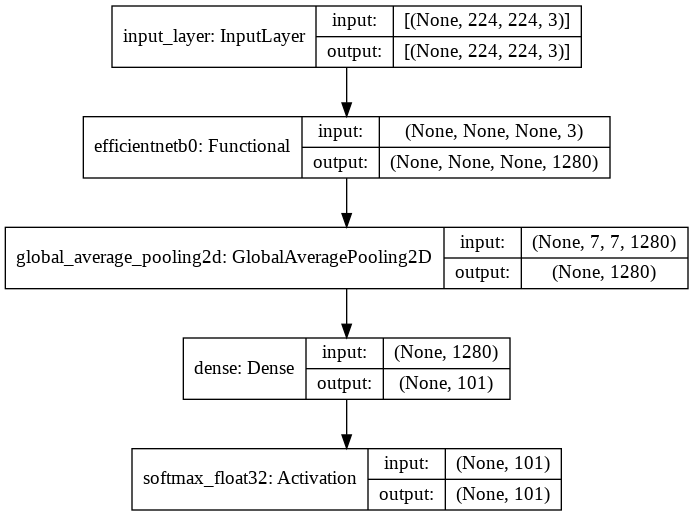

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(loaded_gs_model, show_shapes=True)

Now that the model is compiled, we can fit it on all the data.  

We'll set it up to run for up to 100 epochs.  

> Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs. 

> 🔑 **Note:** Running the cell below will set the model up to: 
> * Fine-Tune **all of the pretrained weights** in the base model on all of the Food101 data.
> * Doing so with **unoptimized data pipelines** and **without mixed precision** training will take fairly long time per epoch.

In [ ]:
# Start to fine-tune (all layers)

history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(x=train_data,
                                                                  epochs=100,
                                                                  steps_per_epoch=len(train_data),
                                                                  validation_data=test_data,
                                                                  validation_steps=int(0.15 * len(test_data)),
                                                                  callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                                         experiment_name="efficientb0_101_food_classes_all_data_fine_tuning"),
                                                                             model_checkpoint,
                                                                             early_stopping,
                                                                             reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_food_classes_all_data_fine_tuning/20211011-060811
Epoch 1/100
2368/2368 [==============================] - 1116s 457ms/step - loss: 0.9734 - accuracy: 0.7413 - val_loss: 0.8219 - val_accuracy: 0.7672
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 1064s 448ms/step - loss: 0.5911 - accuracy: 0.8383 - val_loss: 0.8143 - val_accuracy: 0.7847
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 1063s 448ms/step - loss: 0.3226 - accuracy: 0.9097 - val_loss: 0.8803 - val_accuracy: 0.7828
Epoch 4/100
2368/2368 [==============================] - 1062s 448ms/step - loss: 0.1634 - accuracy: 0.9526 - val_loss: 0.9792 - val_accuracy: 0.7810

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 1062s 448ms/step - loss: 0.0476 - accuracy: 0.9889 - val_loss: 1.0447 - val_accuracy: 0.7993


Let's make sure we save our model before we start evaluating it.  

In [ ]:
# Save model to Google drive: (optional)
# "/content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
loaded_gs_model.save("/content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [ ]:
# Save model locally in Google Colab instance
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


It looks like our model has gained a few performance points from fine-tuning, let's evaluate the whole test dataset and see if we managed to beat the [DeepFood paper](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.  

In [ ]:
# Evaluate the mixed precision trained model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 72s 91ms/step - loss: 1.0465 - accuracy: 0.7977


[1.0465078353881836, 0.7976633906364441]

GREAT! It looks like our model beat the results mentioned in the DeepFood paper for Food101 (DeepFood's $77.4%$ top-1 accuracy vs. our ~$79%$ top-1 accuracy.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Download Fine-tuned model from Google Storage  

As mentioned before, training models can take a significant amount of time.  

This is a model from ZTM's google storage:  

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2021-10-11 07:56:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M   102MB/s    in 0.4s    

2021-10-11 07:56:45 (102 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # Create seperate directory for fine-tuned model downloaded from GS
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


Now we can load it in using the `tf.keras.models.load_model()` and get a summary.  

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate 
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work

results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 74s 91ms/step - loss: 0.9072 - accuracy: 0.8017


[0.9072414040565491, 0.801663339138031]

In [ ]:
# Reloading from our own Google Drive
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/drive/MyDrive/TDC/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

# Get a summary 
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 72s 91ms/step - loss: 1.0465 - accuracy: 0.7977


[1.0465078353881836, 0.7976633906364441]

Our saved model is performing as expected (better results than DeepFood paper's)  

CONGRATS! We trained a Computer Vision model with competitive performance to a research paper in far less time (our model took ~90 minutes to train versus. DeepFood's quoted 2-3 days).  

If you really wanted to step things up, we could try using the EfficientNetB$4$ model (a larger version of EfficientNetB$0$).  

# View training results on TensorBoard  

Since we tracked our model's fine-tuning logs using the TensorBoard callback, let's upload them and inspect them on TensorBoard.dev  

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 data" \
  --description "Training Results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2021-10-11 08:14:59.800877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3

View experiment: https://tensorboard.dev/experiment/YgMeAGLyRZO12da7eRDgcQ/  

Viewing at our model's [training curves on TensorBoard.dev](https://tensorboard.dev/experiment/YgMeAGLyRZO12da7eRDgcQ/), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.  

> To fix this in future experiments, we might try things like:  
> * A different iteration of EfficientNet (e.g EfficientNetB4 instead of EfficientNetB0)  
> * Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.  

In [ ]:
# View past TensorBoard experiments
!tensorboard dev list

2021-10-11 08:21:27.964487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/YgMeAGLyRZO12da7eRDgcQ/
	Name                 Fine-tuning EfficientNetB0 on all Food101 data
	Description          Training Results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   YgMeAGLyRZO12da7eRDgcQ
	Created              2021-10-11 08:15:27 (6 minutes ago)
	Updated              2021-10-11 08:15:29 (6 minutes ago)
	Runs                 4
	Tags                 3
	Scalars              32
	Tensor bytes         0
	Binary object bytes  2081463
https://tensorboard.dev/experiment/pLYnr5SMR6y3LhyR5tqkSQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different Transfer Learning experiments with varying amounts of data and fine-tuning.
	Id                   pLYnr5SMR6y3LhyR5tqkSQ
	Created              2021

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
!tensorboard dev delete --experiment_id YgMeAGLyRZO12da7eRDgcQ

2021-10-11 08:23:34.079565: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Deleted experiment YgMeAGLyRZO12da7eRDgcQ.


Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.